# SBRA2020チュートリアル：手書き数字認識の学習・評価

学習・評価データセット…MNIST

ネットワーク…CNN3

## 1. 学習

### 1.1. 必要モジュールのインポート

In [ ]:
from __future__ import print_function

# 基本
import copy
import math
import time
import numpy as np

# Matplotlib関連
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# PyTorch関連
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

# sklearn関連
from sklearn.metrics import roc_curve

### 1.2. ネットワーク(CNN)を定義

In [ ]:
# ArcFaceのクラス
class ArcFaceClassifier(nn.Module):
    def __init__(self, in_features, num_class, s = 30, m=0.5):
        super(ArcFaceClassifier, self).__init__()
        self.s = s
        self.m = m
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        self.weight = nn.Parameter(torch.FloatTensor(num_class, in_features))
        nn.init.xavier_normal_(self.weight)

    def forward(self, input, label=None, use_arcface=True):
        if use_arcface==False:
            cosine = F.linear(input, self.weight)
            return cosine
        else:
            x = F.normalize(input, p=2)
            weight = F.normalize(self.weight, p=2)
            cosine = F.linear(x, weight)
            if label is None:
                return cosine
            theta = torch.acos(torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7))
            m_cosine = torch.cos(theta + self.m)
            m_cosine = torch.where(cosine > self.th, m_cosine, cosine - self.mm)
            one_hot = torch.zeros_like(cosine)
            one_hot.scatter_(1, label.view(-1, 1).long(), 1)
            output = self.s * (cosine * (1 - one_hot) + m_cosine * one_hot)  
            return output

In [ ]:
# CNNのクラス
class Net_MNIST_ArcFace(nn.Module):
    def __init__(self):
        super(Net_MNIST_ArcFace, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 24, 5, 2, 2),            # 1x28x28 -> 24x14x14
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 48, 5, 2, 2),           # 24x14x14 -> 48x7x7
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 96, 5, 2, 2),           # 48x7x7 -> 96x4x4
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 4, 1, 0, 1, 96),    # 96x4x4 -> 96x1x1 (global depth-wise convolution)
            nn.Flatten(),
            nn.Linear(96, 3)                      # 96 -> 3
        )
        self.classifier = ArcFaceClassifier(3, 10, 30.0, 0.5) 

    def forward(self, x, label=None, use_arcface=True):
        x = self.features(x)
        x = self.classifier(x, label, use_arcface)
        return F.log_softmax(x, dim=1)        

### 1.3. CNNの学習・評価の関数を定義

In [ ]:
# CNNを学習する関数
def train(model, device, train_loader, optimizer, epoch, use_arcface):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, target, use_arcface)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{:>5}/{} ({:>2}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                int(100. * batch_idx / len(train_loader)), loss.item()))

# CNNを評価する関数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### 1.3. 各種パラメータを設定

In [ ]:
# 超パラメータ設定
batch_size_train = 128
batch_size_test = 1000
epochs = 3
lr = 0.01
momentum = 0.9
weight_decay = 0.00001

no_cuda = False
seed = 0
save_model = False

# CPU/GPU(CUDA)の状態
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# シード設定
torch.manual_seed(seed)

# numpyのprint出力の設定
np.set_printoptions(suppress=True, precision=5, floatmode='fixed')

### 1.4. Datasetを作成

In [ ]:
# MNISTのDatasetを作成
train_dataset_MNIST = datasets.MNIST('./data', train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
test_dataset_MNIST = datasets.MNIST('./data', train=False, 
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


### 1.5. DataLoaderを作成

In [ ]:
# 学習・評価用のDataLoaderを作成
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    train_dataset_MNIST, batch_size=batch_size_train, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_dataset_MNIST, batch_size=batch_size_test, shuffle=False, **kwargs)

### 1.6. MNISTのサンプルを描画

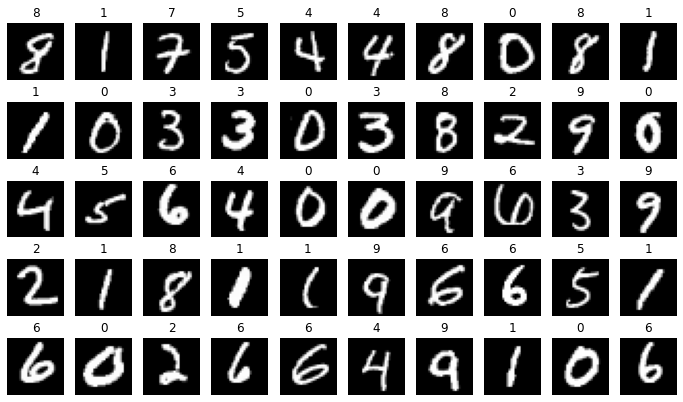

In [ ]:
# MNISTのサンプル表示用にDataLoaderを作成、描画
col = 10
row = 5
sample_dataset_MNIST = datasets.MNIST('./data', train=False, 
    transform=transforms.Compose([transforms.ToTensor()]))
sample_loader = torch.utils.data.DataLoader(
    sample_dataset_MNIST, batch_size=col*row, shuffle=True, **kwargs)
plt.figure(figsize=(12, 7))
for i, (imgs, labels) in enumerate(sample_loader):
    for j in range(0, col*row):
        img = (imgs[j].permute(1, 2, 0) * 255).to(torch.uint8)
        plt.subplot(row, col, j+1)
        plt.imshow(np.squeeze(img), cmap='gray')
        plt.title(f'{labels[j]}')
        plt.axis('off')
    break

### 1.7. モデルを生成

In [ ]:
# モデルを生成
model = Net_MNIST_ArcFace().to(device)

# ネットワーク情報を表示
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 14, 14]             624
              ReLU-2           [-1, 24, 14, 14]               0
            Conv2d-3             [-1, 48, 7, 7]          28,848
              ReLU-4             [-1, 48, 7, 7]               0
            Conv2d-5             [-1, 96, 4, 4]         115,296
              ReLU-6             [-1, 96, 4, 4]               0
            Conv2d-7             [-1, 96, 1, 1]           1,632
           Flatten-8                   [-1, 96]               0
            Linear-9                    [-1, 3]             291
ArcFaceClassifier-10                   [-1, 10]              30
Total params: 146,721
Trainable params: 146,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.56
Estimated T

### 1.8. モデルを学習
Softmaxで学習し、ArcFaceで1エポック追加学習する

In [ ]:
# optimizerをSGDに設定
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# モデルを学習(Softmax)
for epoch in range(1, epochs+1):
  train(model, device, train_loader, optimizer, epoch, use_arcface=False)
  test(model, device, test_loader)
model_1 = copy.deepcopy(model)

# モデルを学習(ArcFaceで追加学習)
for epoch in range(epochs+1, epochs+3):
  train(model, device, train_loader, optimizer, epoch, use_arcface=True)
  test(model, device, test_loader)
model_2 = copy.deepcopy(model)

Train Epoch: 1 [    0/60000 ( 0%)]	Loss: 2.300804
Train Epoch: 1 [ 6400/60000 (10%)]	Loss: 2.280368
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.864996
Train Epoch: 1 [19200/60000 (31%)]	Loss: 0.916246
Train Epoch: 1 [25600/60000 (42%)]	Loss: 0.827539
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.401050
Train Epoch: 1 [38400/60000 (63%)]	Loss: 0.679169
Train Epoch: 1 [44800/60000 (74%)]	Loss: 0.265134
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.355162
Train Epoch: 1 [57600/60000 (95%)]	Loss: 0.376057

Test set: Average loss: 1.6034, Accuracy: 7949/10000 (79%)

Train Epoch: 2 [    0/60000 ( 0%)]	Loss: 0.325950
Train Epoch: 2 [ 6400/60000 (10%)]	Loss: 0.240445
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.327256
Train Epoch: 2 [19200/60000 (31%)]	Loss: 0.260340
Train Epoch: 2 [25600/60000 (42%)]	Loss: 0.360644
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.128884
Train Epoch: 2 [38400/60000 (63%)]	Loss: 0.222031
Train Epoch: 2 [44800/60000 (74%)]	Loss: 0.097704
Train Epoch: 2 [51200/60000 (85%)]	Loss

## 2. 分析・評価

### 2.1. 学習したCNNで特徴量抽出

In [ ]:
# 特徴量抽出する関数
def embedding(model, device, test_loader):
    feature_list = []
    target_list = []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            features = model.features(data)
            feature_list.append(features.to('cpu').detach())
            target_list.append(target)
    return torch.cat(feature_list, dim=0).numpy().copy(), torch.cat(target_list, dim=0).numpy().copy()

# 特徴量(を列ベクトルにもつ行列)をL2ノルムを1にする関数(L2正規化)
def l2normalize(src):
    dst = src.copy()
    for feature in dst:
        a = np.linalg.norm(feature)
        if a==0:
            continue
        feature /= a
    return dst

In [ ]:
# 特徴量を計算(Softmax版)
features_1_orig, targets_1 = embedding(model_1, device, test_loader)
features_1 = l2normalize(features_1_orig) # L2正規化

# 特徴量を計算(ArcFace版)
features_2_orig, targets_2 = embedding(model_2, device, test_loader)
features_2 = l2normalize(features_2_orig) # L2正規化

### 2.2. 特徴量をプロット

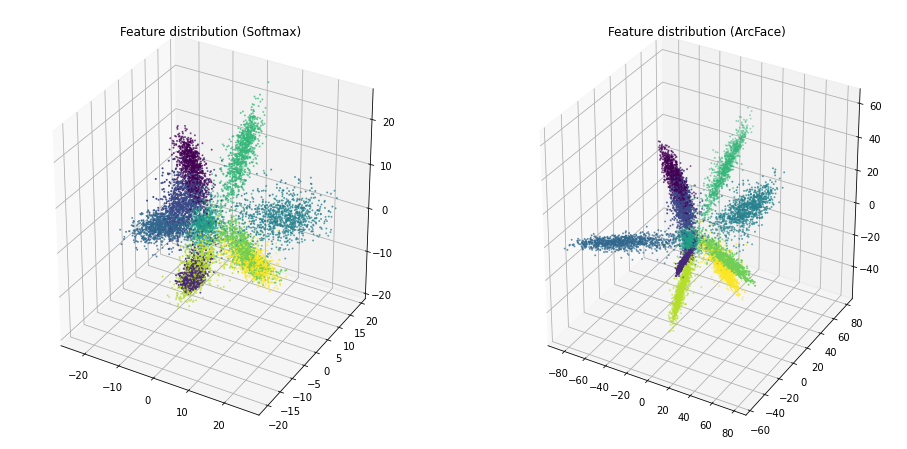

In [ ]:
# 特徴量をプロット(正規化前)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(features_1_orig[::,0], features_1_orig[::,1], features_1_orig[::,2], c=targets_1, s=1)
ax.set_title('Feature distribution (Softmax)')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(features_2_orig[::,0], features_2_orig[::,1], features_2_orig[::,2], c=targets_2, s=1)
a = ax.set_title('Feature distribution (ArcFace)')

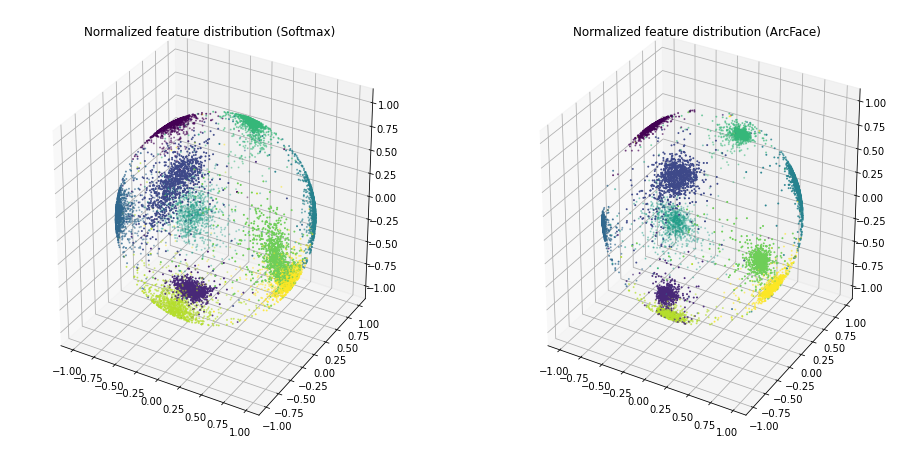

In [ ]:
# 特徴量をプロット(正規化後)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(features_1[::,0], features_1[::,1], features_1[::,2], c=targets_1, s=1)
ax.set_title('Normalized feature distribution (Softmax)')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(features_2[::,0], features_2[::,1], features_2[::,2], c=targets_2, s=1)
a = ax.set_title('Normalized feature distribution (ArcFace)')

### 2.3. スコア(コサイン類似度)を計算

In [ ]:
# スコア(コサイン類似度)行列を計算(Softmax版)
# 10,000枚あるので、10,000×10,000の行列となる
score_matrix_1 = features_1 @ features_1.T

# ラベル(縦ベクトル)
targets_v = np.reshape(targets_1,(len(targets_1),1))
# ラベル(横ベクトル)
targets_h = np.reshape(targets_1,(1,len(targets_1)))

# 同じ数字同士のスコアを抽出(降順ソート)
score_1_mate = np.sort(score_matrix_1[np.where(np.triu(targets_v==targets_h, k=1))])[::-1]
# 異なる数字同士のスコアを抽出(降順ソート)
score_1_nonmate = np.sort(score_matrix_1[np.where(np.triu(targets_v!=targets_h, k=1))])[::-1]

print(score_matrix_1)

[[ 1.00000  0.34106  0.63208 ...  0.46378 -0.86560 -0.26105]
 [ 0.34106  1.00000  0.53380 ... -0.42256 -0.76210 -0.04032]
 [ 0.63208  0.53380  1.00000 ... -0.35862 -0.67083 -0.81937]
 ...
 [ 0.46378 -0.42256 -0.35862 ...  1.00000 -0.13511  0.45903]
 [-0.86560 -0.76210 -0.67083 ... -0.13511  1.00000  0.13878]
 [-0.26105 -0.04032 -0.81937 ...  0.45903  0.13878  1.00000]]


In [ ]:
# スコア(コサイン類似度)行列を計算(5エポック版)
# 10,000枚あるので、10,000×10,000の行列となる
score_matrix_2 = features_2 @ features_2.T

# ラベル(縦ベクトル)
targets_v = np.reshape(targets_2,(len(targets_2),1))
# ラベル(横ベクトル)
targets_h = np.reshape(targets_2,(1,len(targets_2)))

# 同じ数字同士のスコアを抽出(降順ソート)
score_2_mate = np.sort(score_matrix_2[np.where(np.triu(targets_v==targets_h, k=1))])[::-1]
# 異なる数字同士のスコアを抽出(降順ソート)
score_2_nonmate = np.sort(score_matrix_2[np.where(np.triu(targets_v!=targets_h, k=1))])[::-1]

print(score_matrix_2)

[[ 1.00000  0.24361  0.51757 ...  0.49671 -0.71840 -0.41925]
 [ 0.24361  1.00000  0.32507 ... -0.01049 -0.73259 -0.23292]
 [ 0.51757  0.32507  1.00000 ... -0.48285 -0.16442 -0.99044]
 ...
 [ 0.49671 -0.01049 -0.48285 ...  1.00000 -0.61465  0.57969]
 [-0.71840 -0.73259 -0.16442 ... -0.61465  1.00000  0.02708]
 [-0.41925 -0.23292 -0.99044 ...  0.57969  0.02708  1.00000]]


### 2.4. スコアの確率分布を描画

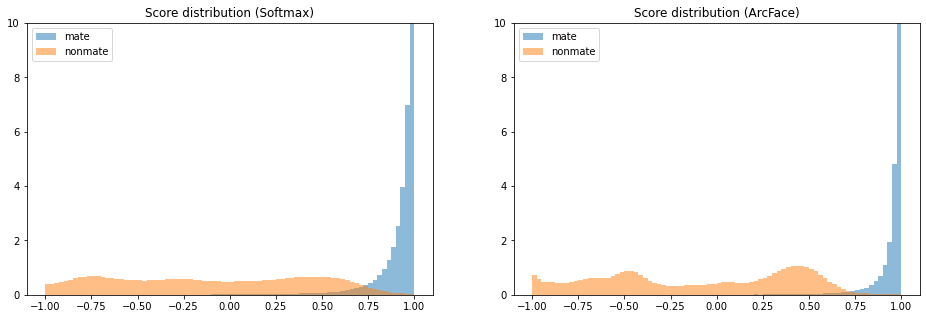

In [ ]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(121)
ax.hist(score_1_mate, alpha=0.5, density=True, bins=80, label='mate')
ax.hist(score_1_nonmate, alpha=0.5, density=True, bins=80, label='nonmate')
ax.set_ylim(0, 10)
ax.set_title('Score distribution (Softmax)')
ax.legend(loc=2)
ax = fig.add_subplot(122)
ax.hist(score_2_mate, alpha=0.5, density=True, bins=80, label='mate')
ax.hist(score_2_nonmate, alpha=0.5, density=True, bins=80, label='nonmate')
ax.set_ylim(0, 10)
ax.set_title('Score distribution (ArcFace)')
ax.legend(loc=2)

### 2.5. FAR・FRR・閾値を計算

In [ ]:
grandtruth = np.concatenate((np.ones_like(score_1_mate), np.zeros_like(score_1_nonmate)))
score_1 = np.concatenate((score_1_mate, score_1_nonmate))
score_2 = np.concatenate((score_2_mate, score_2_nonmate))

far_1, tar_1, thresholds_1 = roc_curve(grandtruth, score_1)
frr_1 = 1 - tar_1

far_2, tar_2, thresholds_2 = roc_curve(grandtruth, score_2)
frr_2 = 1 - tar_2

### 2.6. ROC曲線を描画

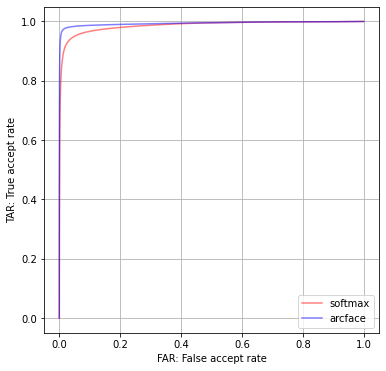

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(far_1, tar_1, alpha=0.5, color='red', label='softmax')
plt.plot(far_2, tar_2, alpha=0.5, color='blue', label='arcface')
plt.xlabel('FAR: False accept rate')
plt.ylabel('TAR: True accept rate')
plt.legend(loc=4)
plt.grid()

### 2.7. DET曲線を描画

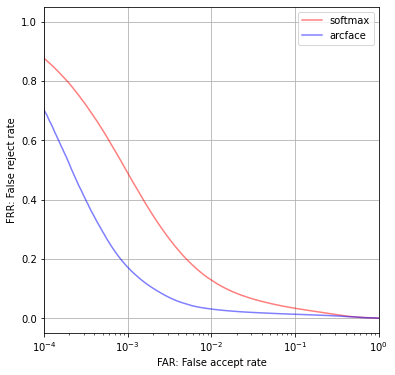

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(far_1, frr_1, alpha=0.5, color='red', label='softmax')
plt.plot(far_2, frr_2, alpha=0.5, color='blue', label='arcface')
plt.xscale('log')
#plt.yscale('log')
plt.xlim([0.0001,1])
plt.xlabel('FAR: False accept rate')
plt.ylabel('FRR: False reject rate')
plt.legend(loc=1)
plt.grid()